## 01_cleaning
  
Author: Mourad Askar

**Download the data from Chicago Data Portal and clean it**  
 
* The notebook creates a couple of local intermediate data files in tmp folder, that can be ignored
* The final output is **crash_df_parquet** that will be used in the following notebooks

In [1]:
import pandas as pd
import numpy as np
import klib
from platform import python_version

%precision 2
pd.set_option('max_columns',200)
pd.set_option('display.precision',2)
pd.set_option('display.float_format','{:,.4f}'.format)

print('python',python_version())
print(np.__name__, np.__version__)
print(pd.__name__, pd.__version__)
print(klib.__name__, klib.__version__)

python 3.9.2
numpy 1.20.1
pandas 1.2.3
klib 0.1.5


In [2]:
file_parquet = './tmp/20210228_chi_crashes.parquet'
file_parquet_c = './tmp/20210228_chi_crashes_c.parquet'

# Download source data 

The sequence of notebooks start from the direct raw download of data from the chicago data portal.

We worked with a snapshot downloaded on 2021-02-28, but the whole process is expected to be re-executable without any issues as in later stages we filter down the working data to just include the years of 2018,2019,2020, which are all in the past so we don't expect them to change.

Also, we write the data to parquet format to be able to read and write the huge amount of data faster.

We kept the download code commented out to prevent slowing down the process since we already had local copies.

In [3]:
# Use this code to download the whole dataset from the portal (SLOW)

# df_raw = pd.read_csv('https://data.cityofchicago.org/api/views/85ca-t3if/rows.csv',
#                     low_memory=False, parse_dates=['CRASH_DATE','DATE_POLICE_NOTIFIED'], index_col=0)

In [4]:
# Code to download the dataset in batches to adhere with socrata api 50K data limit

# Set to True to re-download the data from the portal
RE_DOWNLOAD = True

if RE_DOWNLOAD:
    # Data Portal Init
    resource_url = 'https://data.cityofchicago.org/resource/85ca-t3if.csv'

    # Check if api key exists in global configuration
    if("API_KEY_chicago_data_portal_app_token" in globals()):
        api_token = API_KEY_chicago_data_portal_app_token
    else:
        api_token = ''

    # Range of years to download
    years_range = (2018,2020)

    # Records limit per batch (Max = 50,000)
    limit  = 50_000

    # Init offset to zero
    offset = 0

    while(True):
        # Break down the URL for better readability
        full_url  = f'{resource_url}?$$app_token={api_token}&$limit={limit}&$offset={offset}&$order=crash_date'
        full_url += f'&$where=date_extract_y(crash_date)%20between%20{years_range[0]}%20and%20{years_range[1]}'

        print('offset:', offset)
        df_raw_batch = pd.read_csv(full_url, low_memory=False, parse_dates=['crash_date','date_police_notified'], index_col=0)
        print('Batch Records:', df_raw_batch.shape[0])
        if offset == 0:
            df_raw = df_raw_batch.copy()
        else:
            df_raw = df_raw.append(df_raw_batch)
        print('Total Records:', df_raw.shape[0])

        if df_raw_batch.shape[0] < limit:
            # Break if returned batch is less than limit size
            break
        else:
            # Else, offset by batch limit size, and loop again
            offset += limit
        print('-----------------')

    # Write data to local parquet file
    df_raw.to_parquet(file_parquet)
    print()

    print('Total Records:', df_raw.shape[0])
    print()

    # Show data range downloaded
    print(df_raw.crash_date.describe(datetime_is_numeric=True))
    print()

    # Show data info
    print(df_raw.info())
    print()

    # References:
    #        https://dev.socrata.com/docs/datatypes/floating_timestamp.html
    #        https://dev.socrata.com/docs/paging.html

offset: 0
Batch Records: 50000
Total Records: 50000
-----------------
offset: 50000
Batch Records: 50000
Total Records: 100000
-----------------
offset: 100000
Batch Records: 50000
Total Records: 150000
-----------------
offset: 150000
Batch Records: 50000
Total Records: 200000
-----------------
offset: 200000
Batch Records: 50000
Total Records: 250000
-----------------
offset: 250000
Batch Records: 50000
Total Records: 300000
-----------------
offset: 300000
Batch Records: 28790
Total Records: 328790

Total Records: 328790

count                           328790
mean     2019-06-03 21:24:26.500258304
min                2018-01-01 00:00:00
25%                2018-09-10 16:30:00
50%                2019-05-25 14:00:00
75%                2020-02-05 17:01:30
max                2020-12-31 23:55:00
Name: crash_date, dtype: object

<class 'pandas.core.frame.DataFrame'>
Index: 328790 entries, 351626f25a540a0fccbe42fb815b14ae6c75c15676bf7c9dd83cb81039ed1476e1fa16a8dbec85929ab1e186b7a970170ed05f

# Read RAW parquet file

Once the raw data is downloaded once to the local parquet file, you can comment the code in the previous section and only start reading from the local data.

In [5]:
df_raw = pd.read_parquet(file_parquet).reset_index(drop=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328790 entries, 0 to 328789
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   rd_no                          328790 non-null  object        
 1   crash_date_est_i               23367 non-null   object        
 2   crash_date                     328790 non-null  datetime64[ns]
 3   posted_speed_limit             328790 non-null  int64         
 4   traffic_control_device         328790 non-null  object        
 5   device_condition               328790 non-null  object        
 6   weather_condition              328790 non-null  object        
 7   lighting_condition             328790 non-null  object        
 8   first_crash_type               328790 non-null  object        
 9   trafficway_type                328790 non-null  object        
 10  lane_cnt                       91634 non-null   float64       
 11  

GridSpec(6, 6)

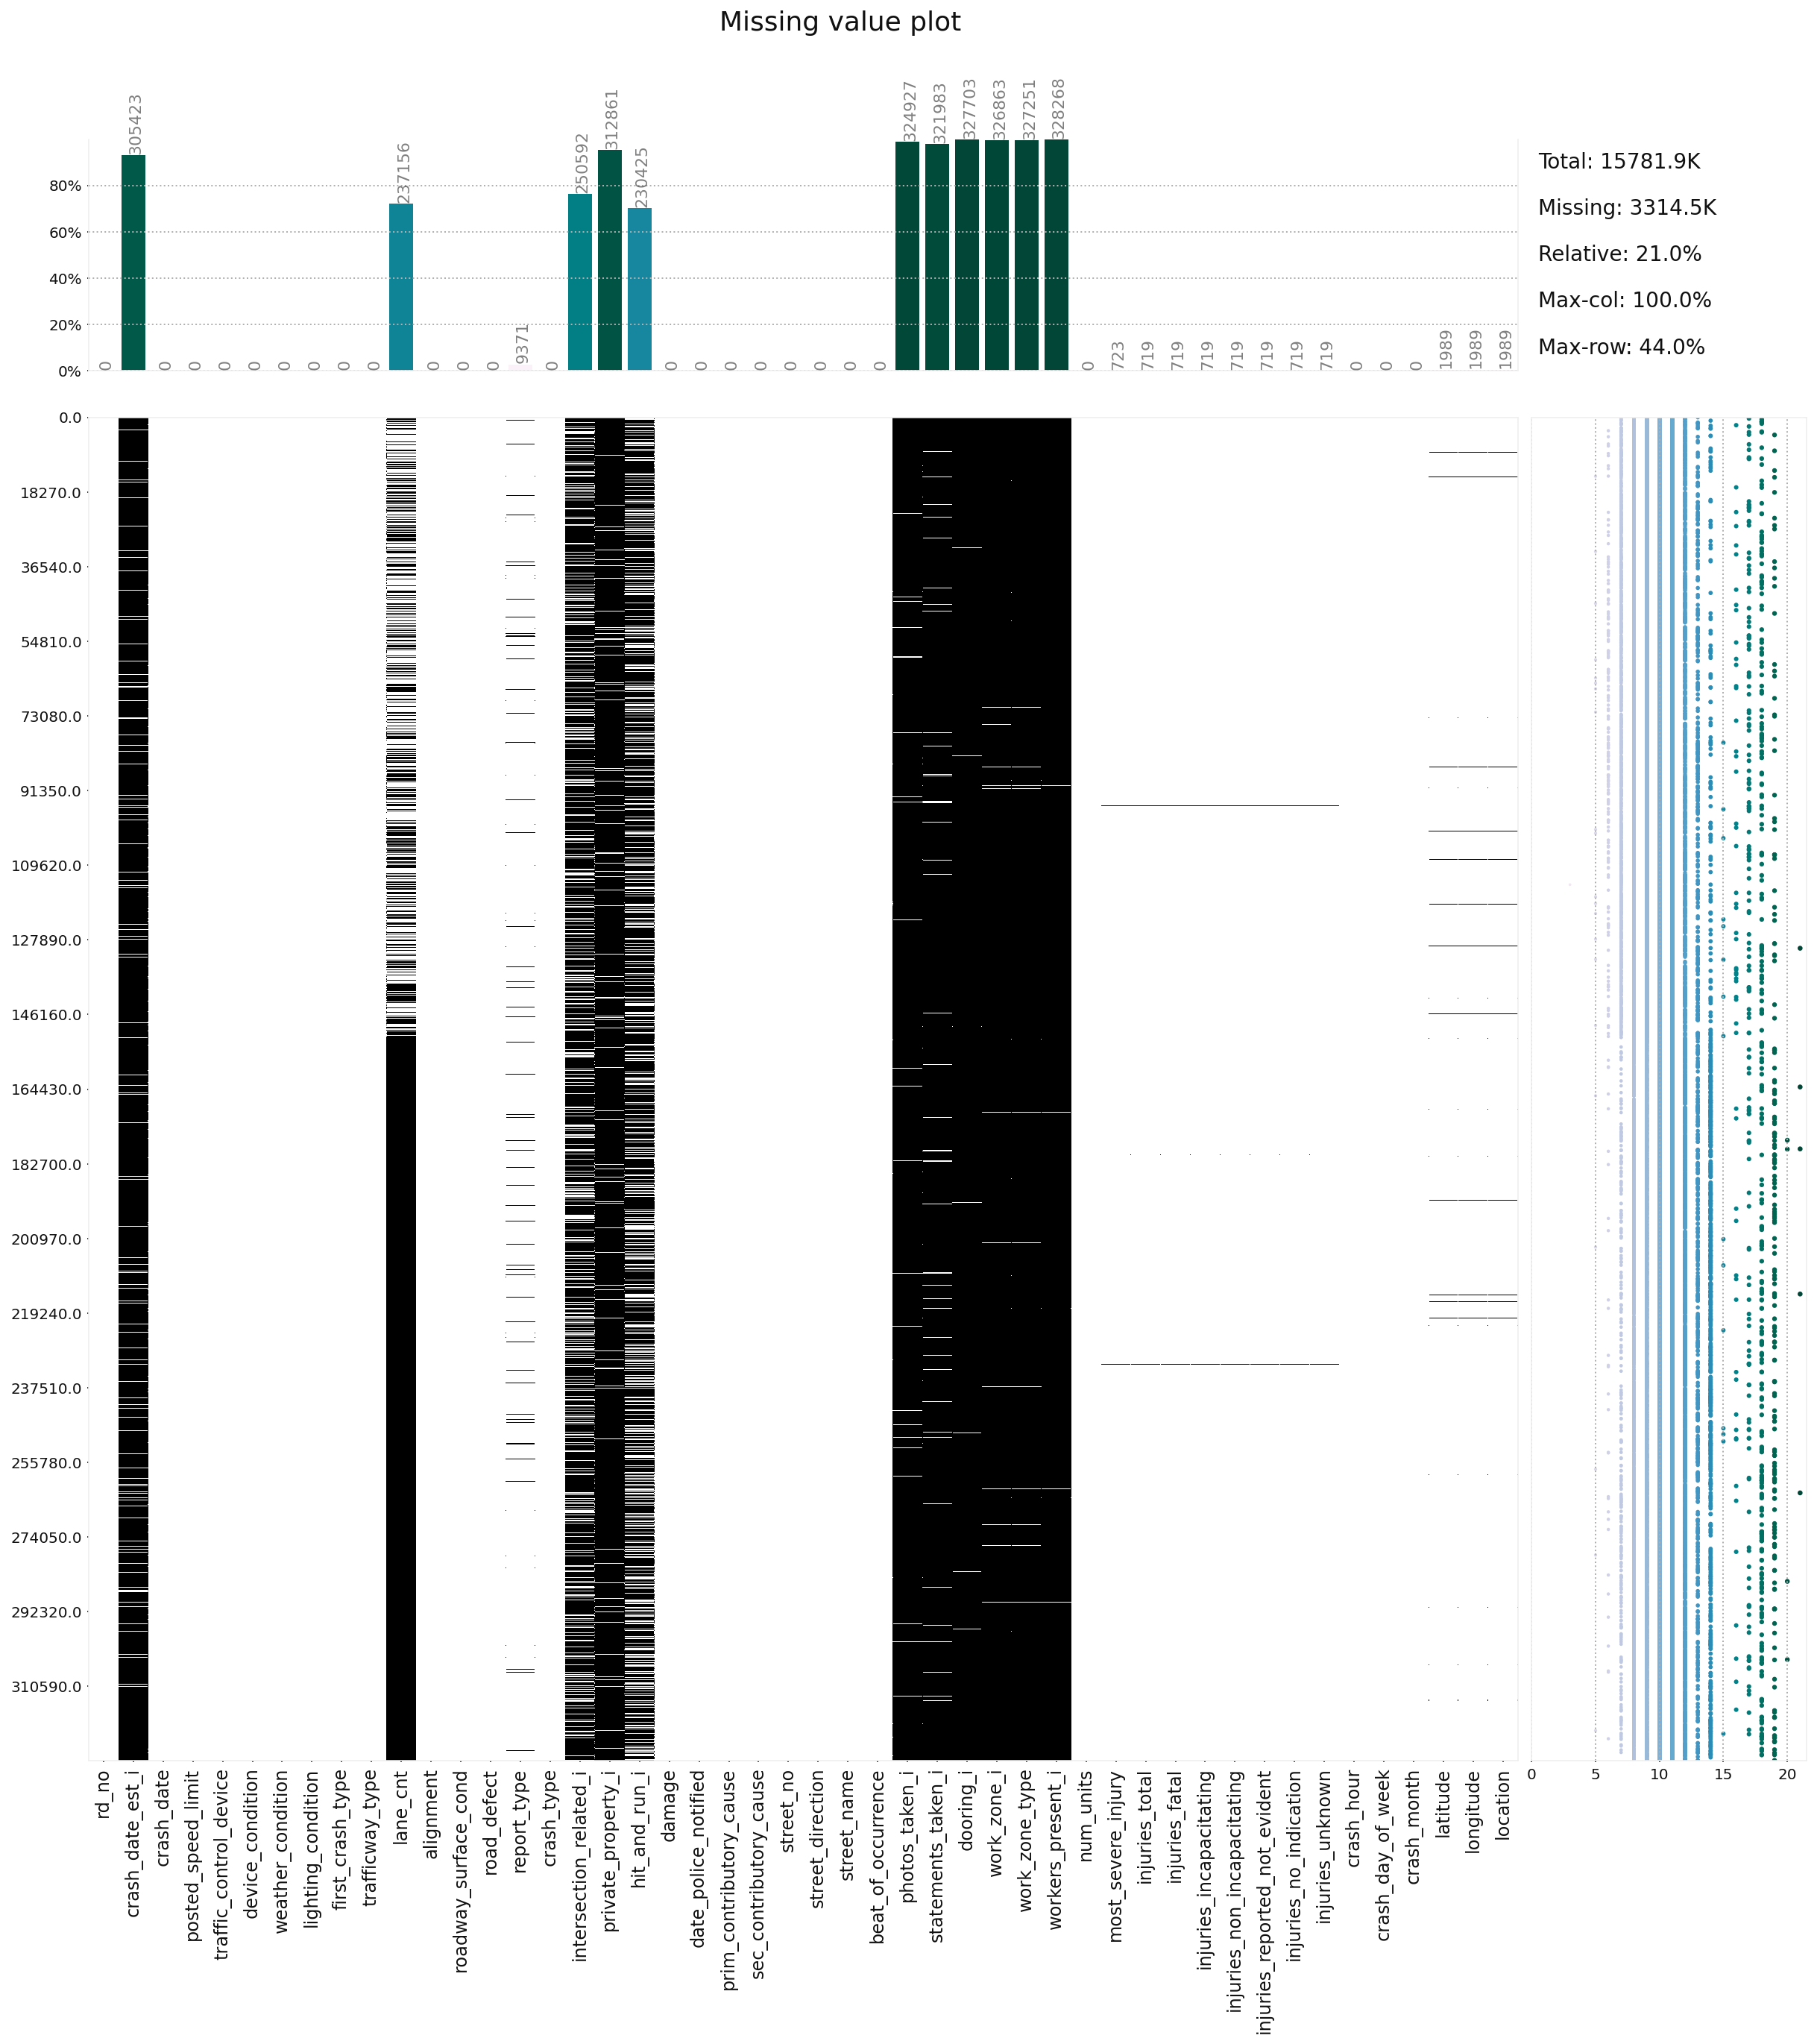

In [6]:
klib.missingval_plot(df_raw)

In [7]:
# Rename long columns
df_1 = df_raw.rename(columns={
    'injuries_non_incapacitating':'inj_non_incap',               
    'injuries_reported_not_evident':'inj_report_not_evdnt'
})

# Drop unwanted columns
df_1.drop(columns=[
    'rd_no','crash_date_est_i','lane_cnt','location','report_type', 'date_police_notified',
    'photos_taken_i','statements_taken_i','dooring_i','work_zone_i','work_zone_type','workers_present_i',
#    'intersection_related_i','not_right_of_way_i','hit_and_run_i', # don't drop these anymore
], inplace=True)

In [8]:
# Clean and standardize column names
df_c = klib.clean_column_names(df_1)

/usr/local/Caskroom/miniconda/base/envs/t1/lib/python3.9/site-packages/klib/clean.py:76: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data.columns.str.replace("\n", "_")


GridSpec(6, 6)

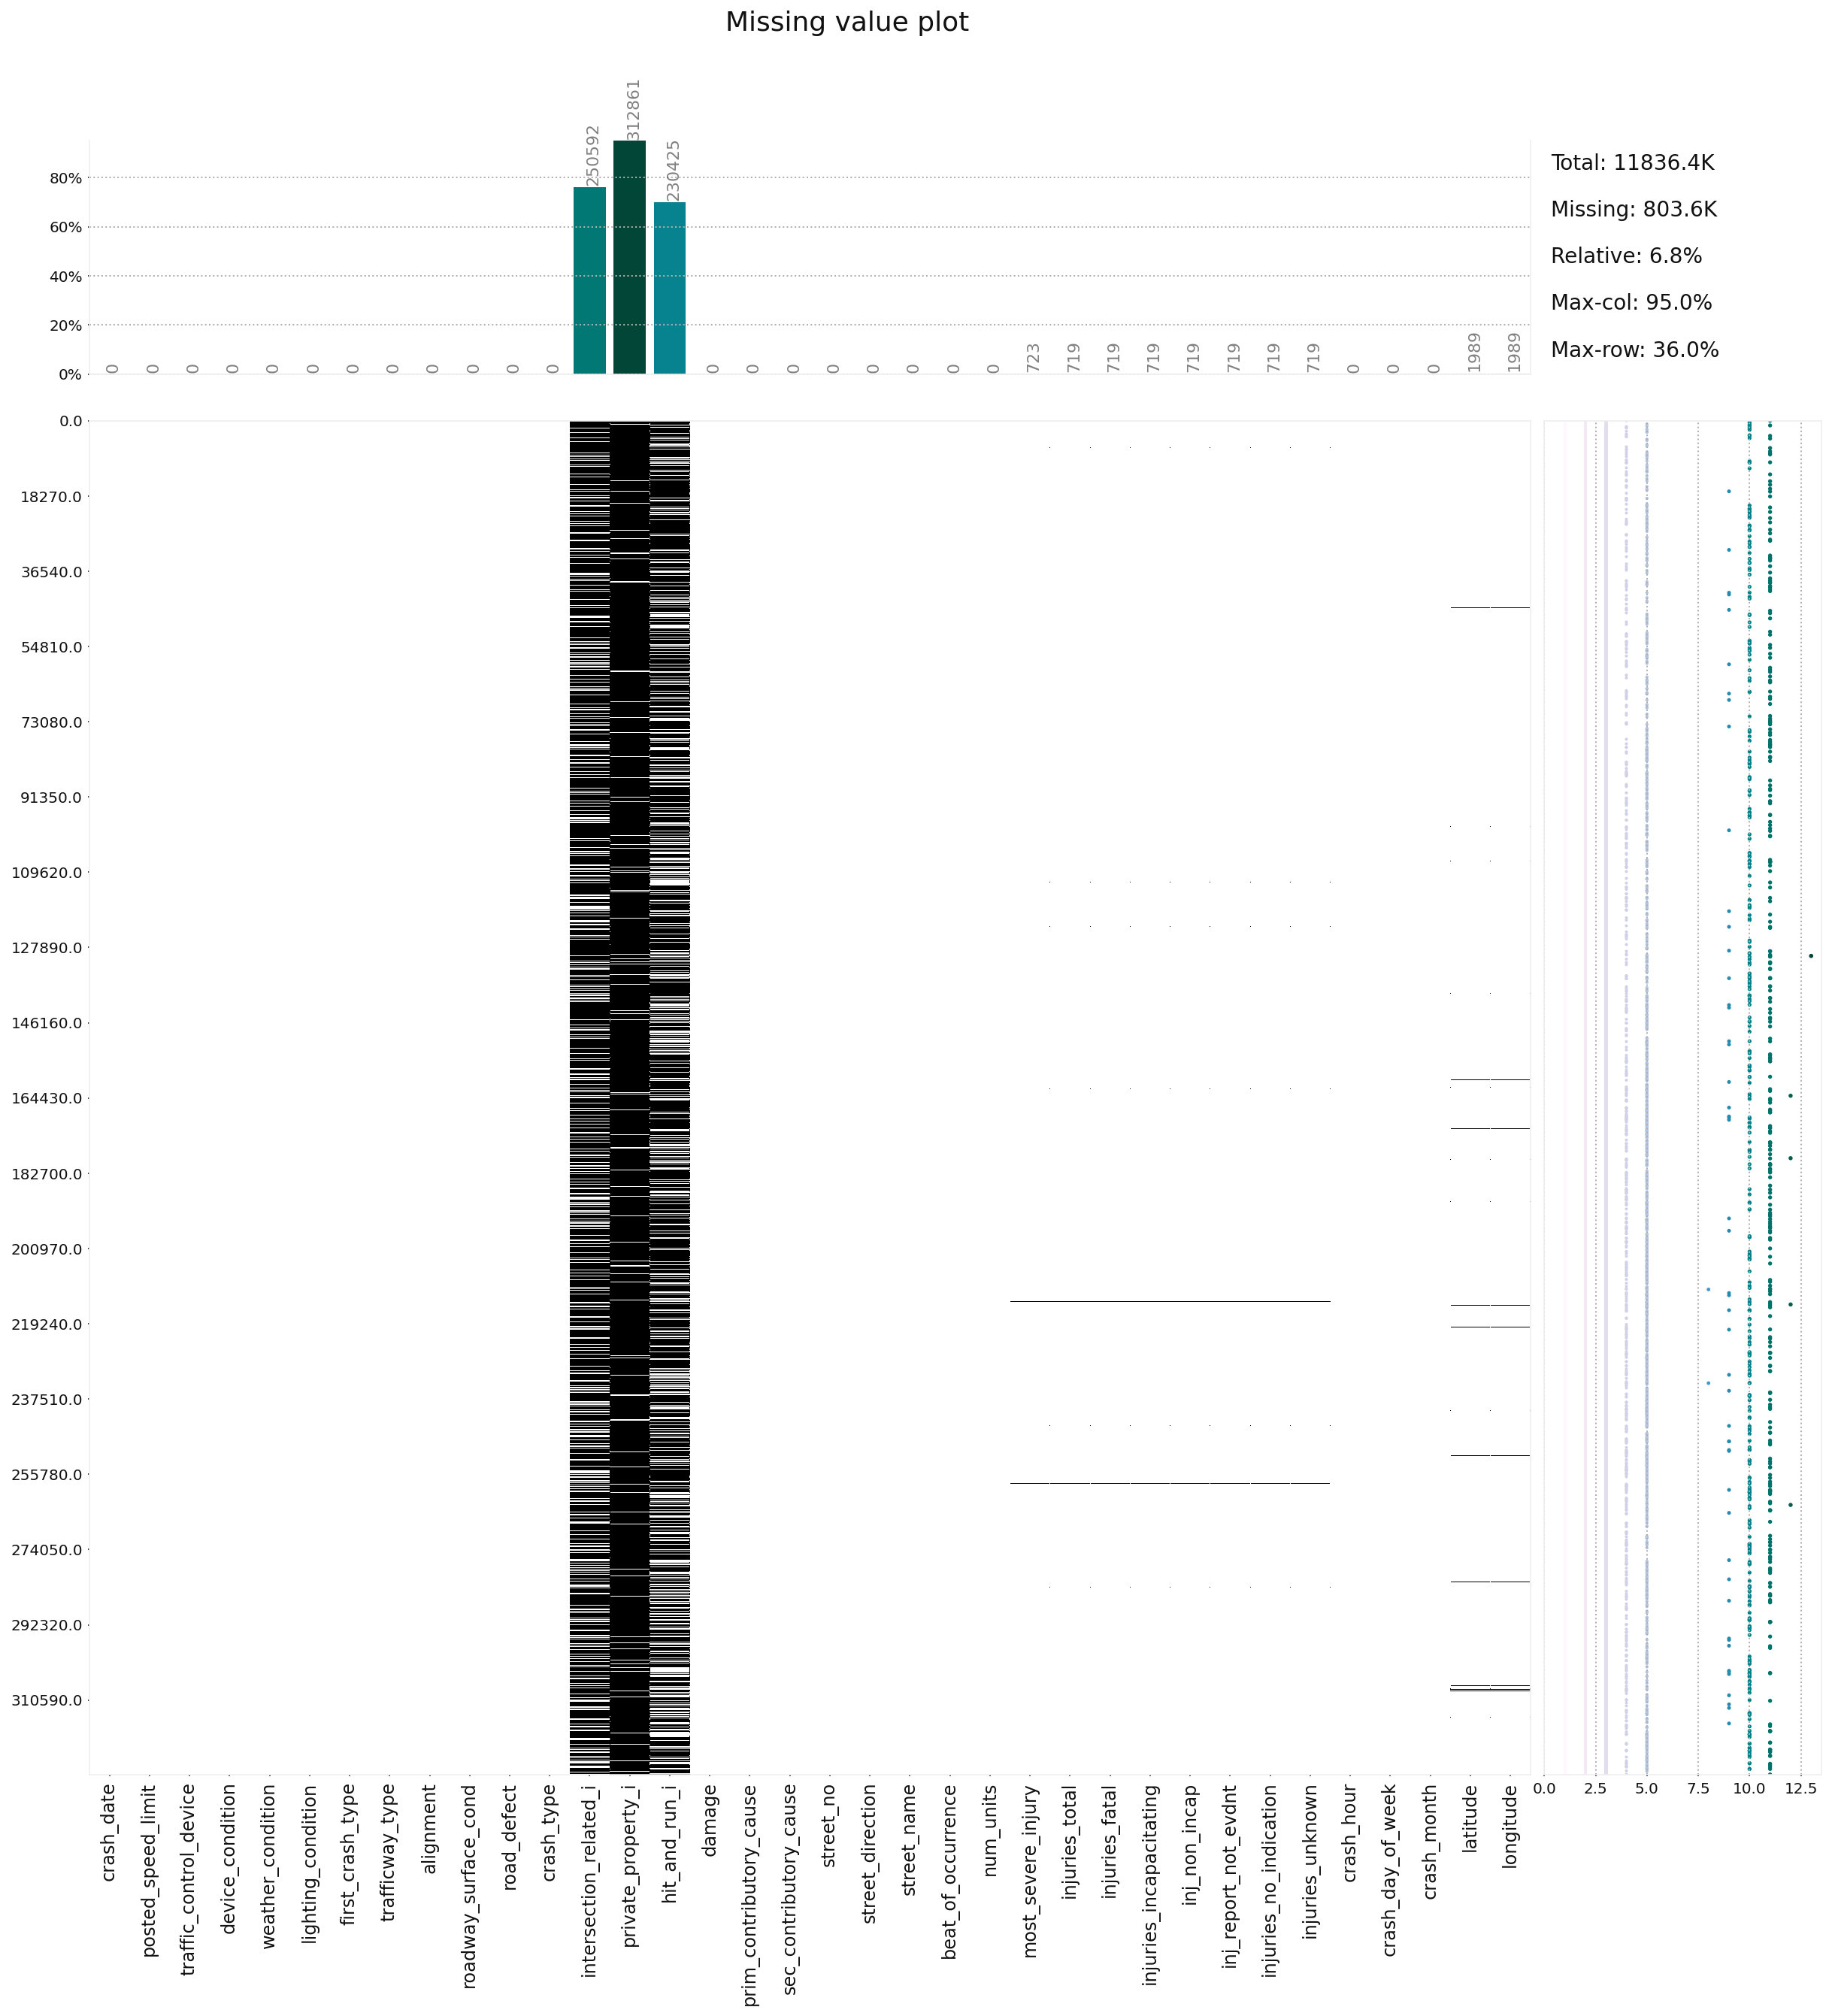

In [9]:
klib.missingval_plot(df_c)

In [10]:
# Fill missing values in these columns with N value, assuming it's the default
df_c.fillna({
    'intersection_related_i':'N',
    'not_right_of_way_i':'N',
    'hit_and_run_i':'N'
}, inplace=True)

GridSpec(6, 6)

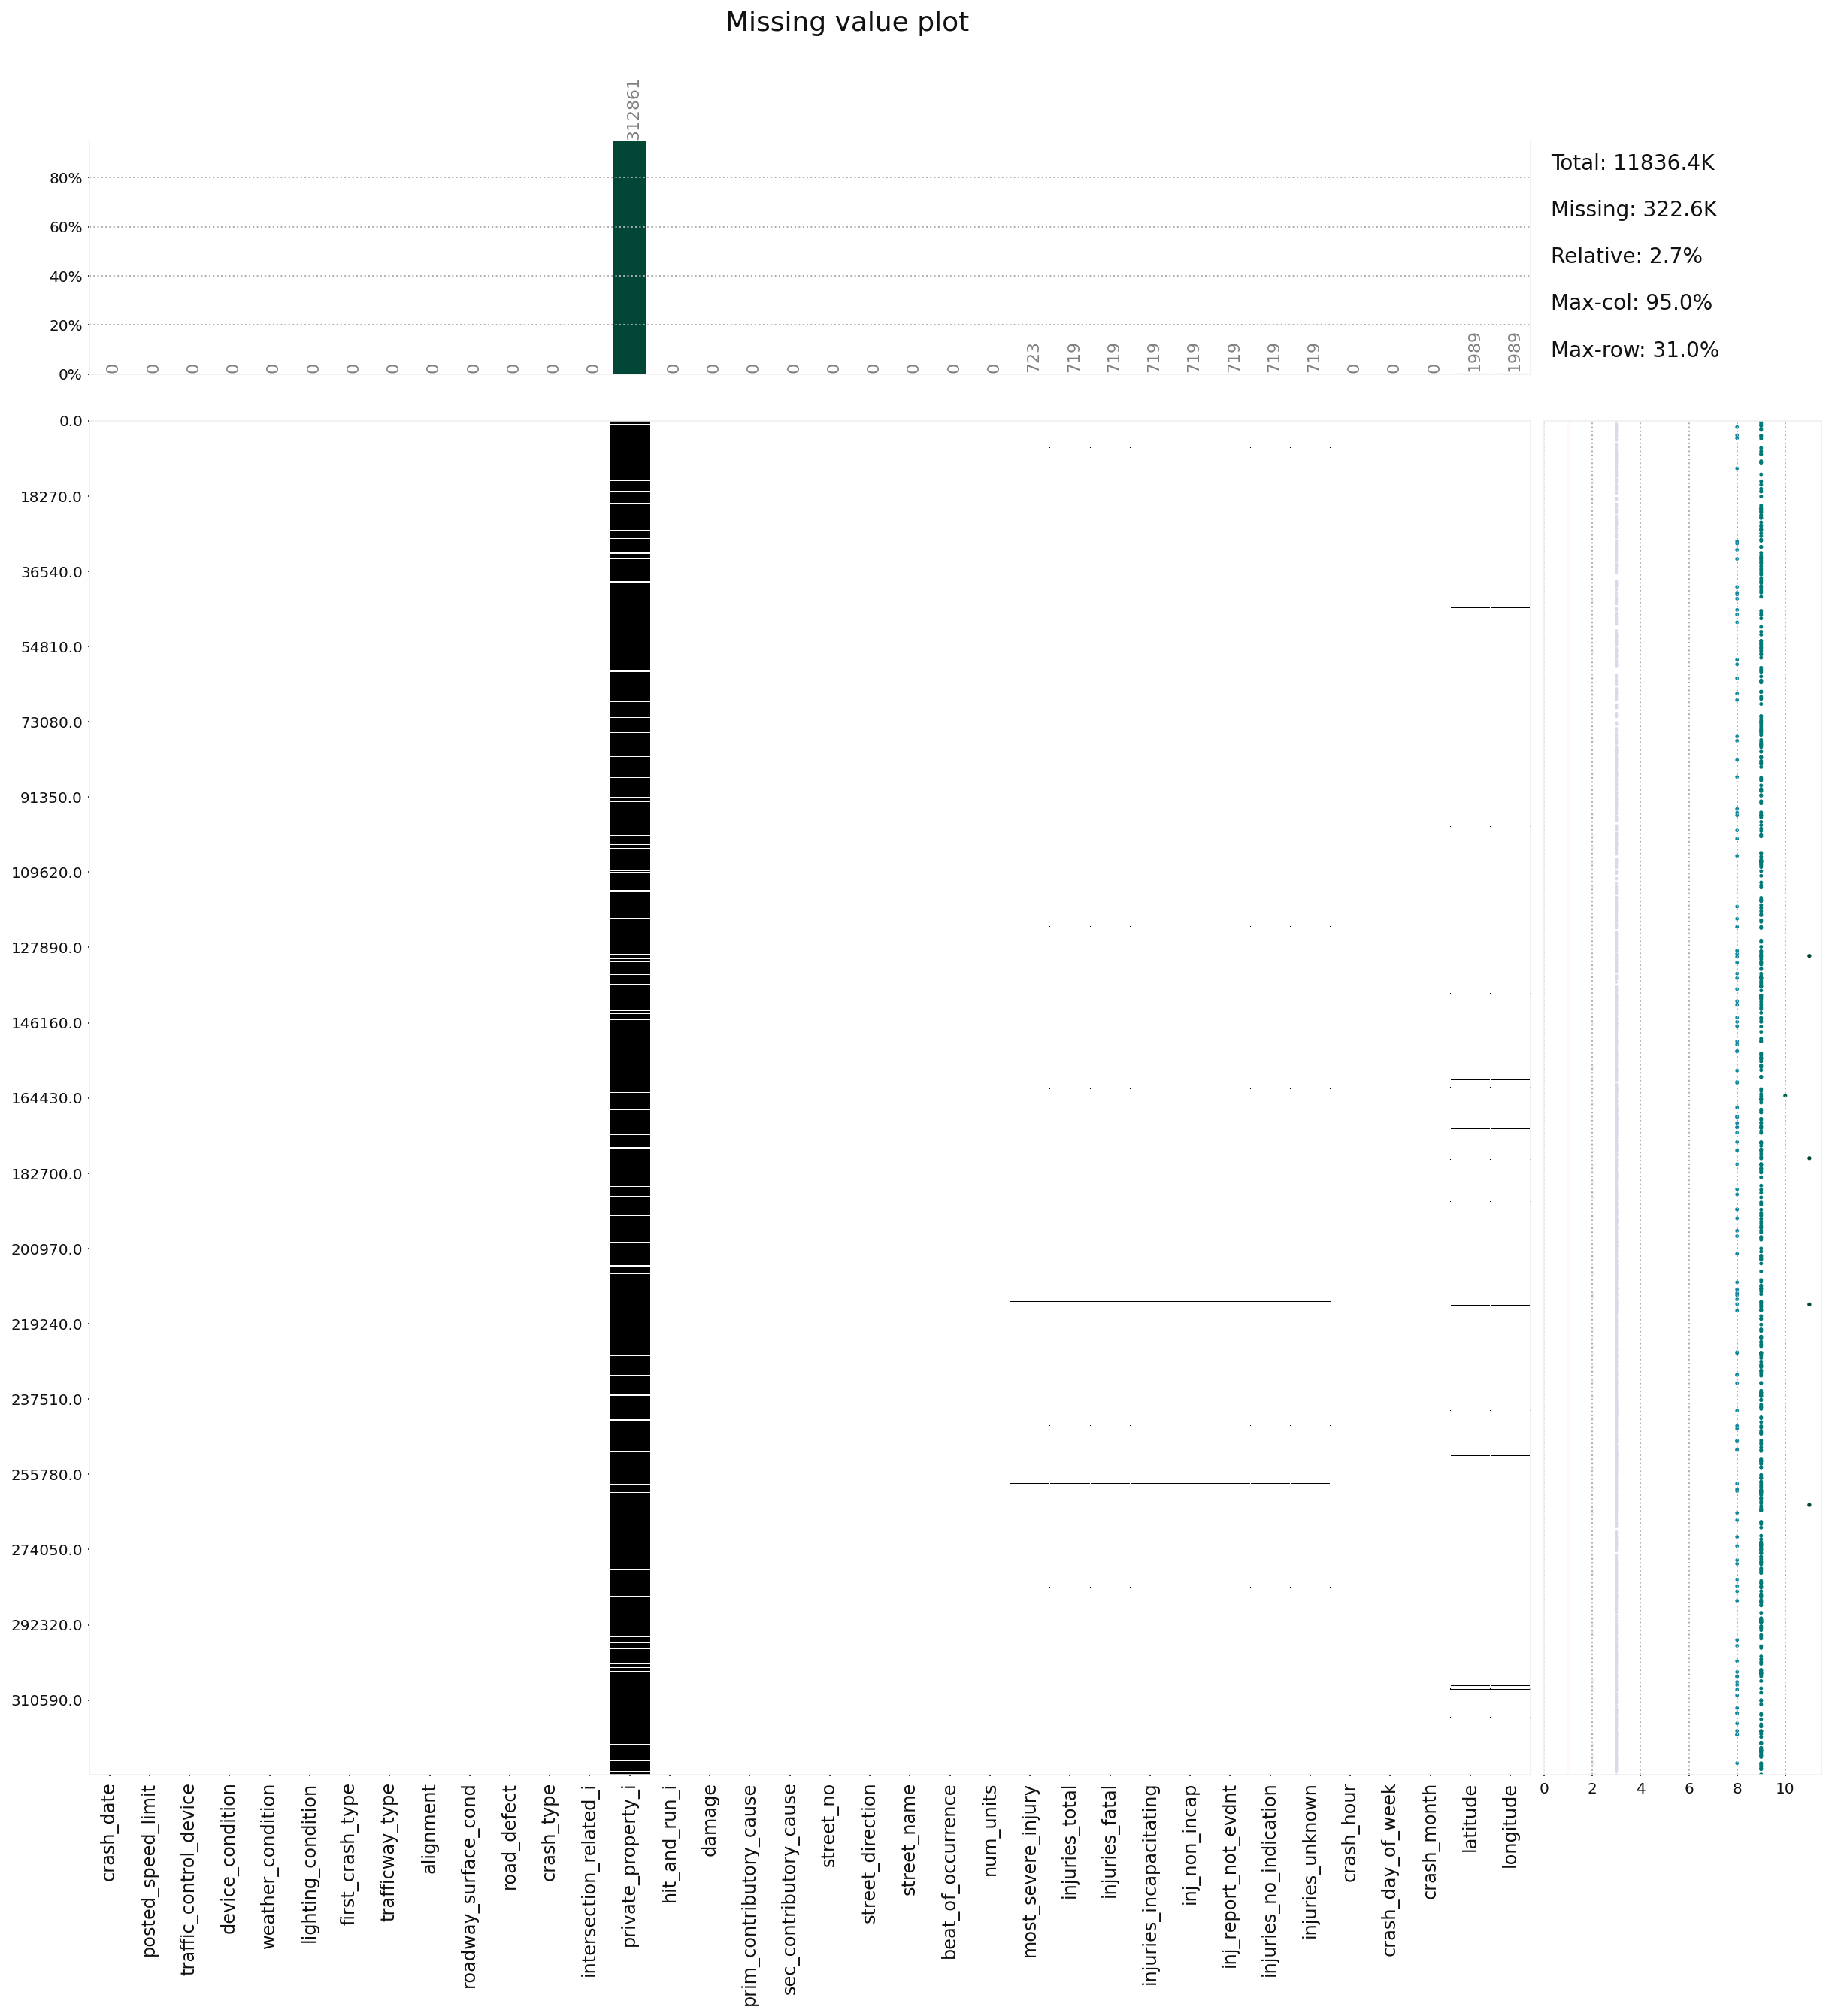

In [11]:
klib.missingval_plot(df_c)

In [12]:
# Set these columns to 0 wherever injuries_total is missing and crash_type is no injury
df_c.loc[((df_c.injuries_total.isna()) & (df_c.crash_type == 'NO INJURY / DRIVE AWAY')),[
          'injuries_total',
          'injuries_fatal',
          'injuries_incapacitating',
          'inj_non_incap',
          'inj_report_not_evdnt',
          'injuries_no_indication',
          'injuries_unknown'
         ]] = 0

In [13]:
# Drop rows where injuries_total is missing
df_c.drop(df_c[df_c.injuries_total.isna()].index, inplace=True)

In [14]:
# Set most_severe_injury = NO INDICATION OF INJURY,
# wherever most_severe_injury is missing and injuries_total is 0
df_c.loc[(df_c.most_severe_injury.isna()) & (df_c.injuries_total == 0),'most_severe_injury'] = 'NO INDICATION OF INJURY'

In [15]:
df_c.most_severe_injury.value_counts(dropna=False)

NO INDICATION OF INJURY     281431
NONINCAPACITATING INJURY     26669
REPORTED, NOT EVIDENT        13996
INCAPACITATING INJURY         6040
FATAL                          360
Name: most_severe_injury, dtype: int64

GridSpec(6, 6)

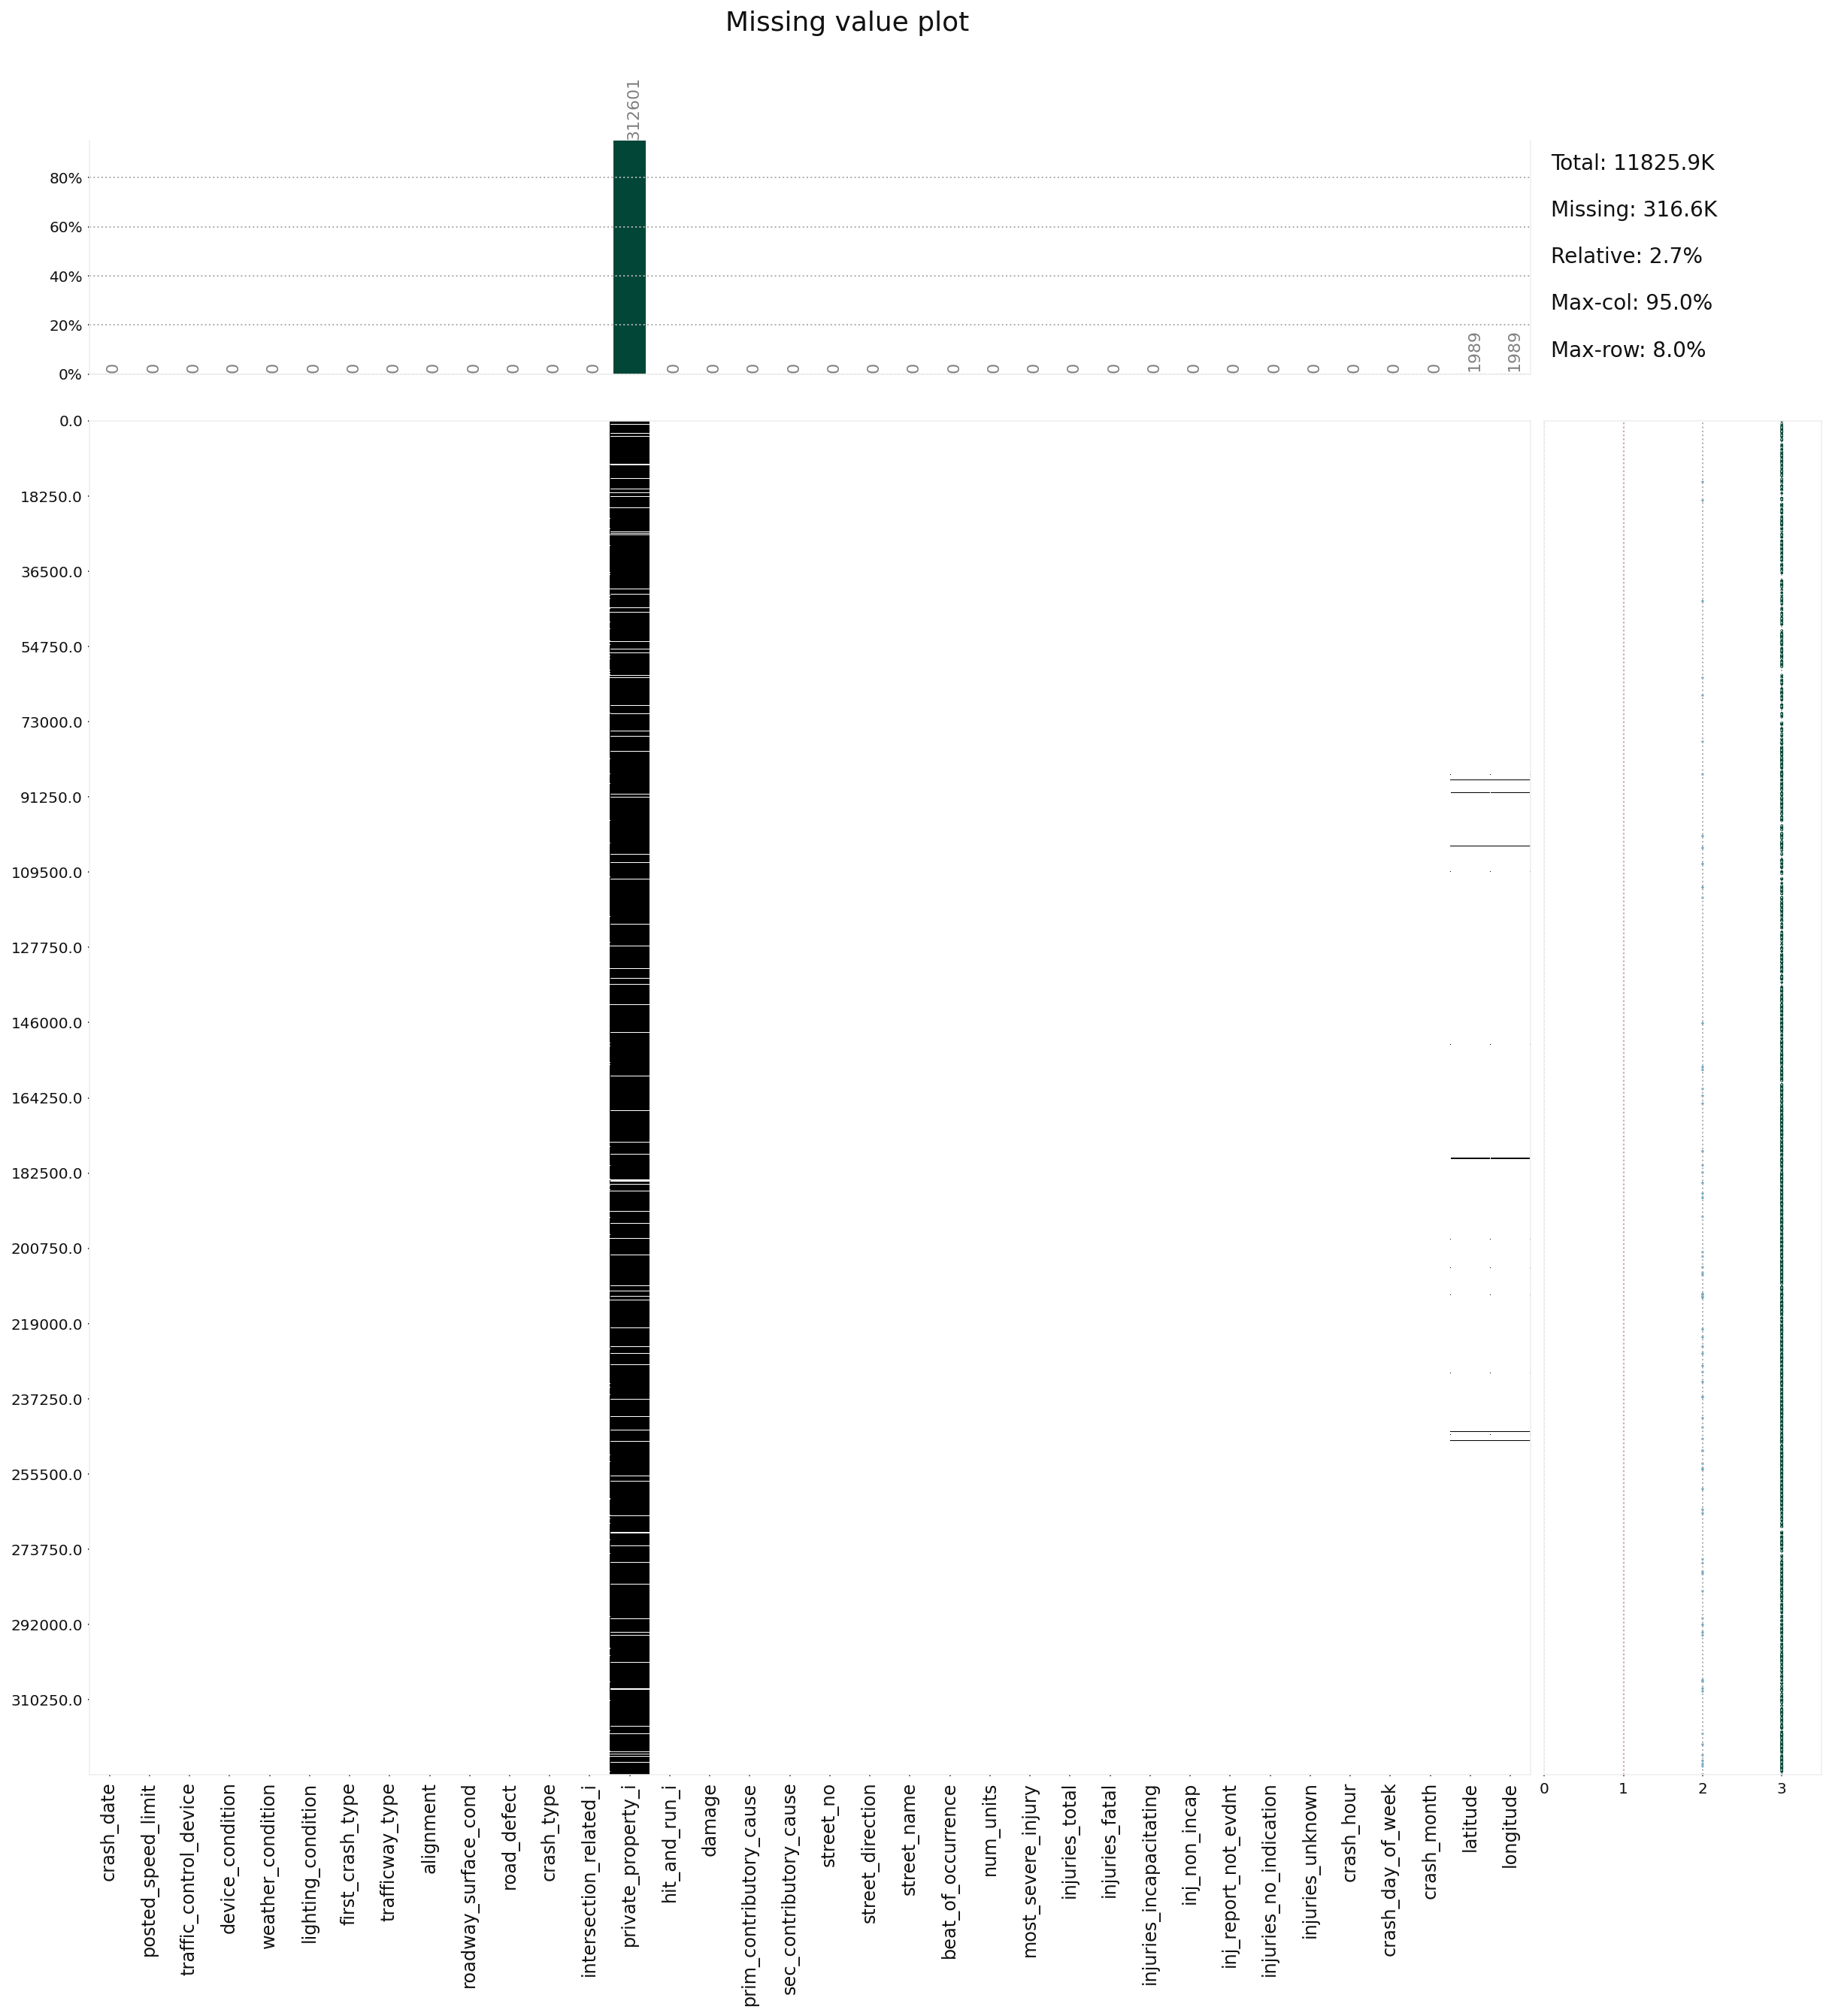

In [16]:
klib.missingval_plot(df_c)

In [17]:
# Fill missing beats

#df_c.loc[240890,'beat_of_occurrence'] = 712
#df_c.loc[304891,'beat_of_occurrence'] = 312
#df_c.loc[340159,'beat_of_occurrence'] = 1711

# Decided to drop records with missing beats. Not worth the step

In [18]:
# create crash year column
df_c['crash_year'] = df_c.crash_date.dt.year

# create address column
#crashes_df2['street_no'] = (crashes_df2['street_no']//100*100).astype(str)
df_c['street_no'] = (df_c['street_no']).astype(str)
df_c['street_direction'] = (df_c['street_direction']).astype(str)
df_c['street_name'] = (df_c['street_name']).astype(str)
df_c['address'] = df_c[['street_no', 'street_direction', 'street_name']].agg(' '.join, axis=1)


In [19]:
# I will not drop duplicates, as they represent repeated incident characteristics, I think it's useful
df_c2 = klib.data_cleaning(df_c, drop_duplicates=False)

/usr/local/Caskroom/miniconda/base/envs/t1/lib/python3.9/site-packages/klib/clean.py:76: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data.columns.str.replace("\n", "_")


Shape of cleaned data: (328496, 36)Remaining NAs: 3978

Changes:
Dropped rows: 0
     of which 0 duplicates. (Rows: [])
Dropped columns: 2
     of which 1 single valued.     Columns: ['injuries_unknown']
Dropped missing values: 312601
Reduced memory by at least: 76.94 MB (-72.72%)



In [20]:
# drop rows that have both long and lat == 0
df_c2 = df_c2.query('latitude != 0 and longitude !=0')

In [21]:
# At this point, Drop any rows that still has NA's
df_c2.dropna(axis=0, inplace=True)

In [22]:
# Fix floats that should be int after we got rid of NA values
df_c2.beat_of_occurrence = df_c2.beat_of_occurrence.astype(int)
df_c2.injuries_total = df_c2.injuries_total.astype(int)
df_c2.injuries_fatal = df_c2.injuries_fatal.astype(int)
df_c2.injuries_incapacitating = df_c2.injuries_incapacitating.astype(int)
df_c2.inj_non_incap = df_c2.inj_non_incap.astype(int)
df_c2.inj_report_not_evdnt = df_c2.inj_report_not_evdnt.astype(int)
df_c2.injuries_no_indication = df_c2.injuries_no_indication.astype(int)


In [23]:
df_c2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326488 entries, 0 to 328789
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   crash_date               326488 non-null  datetime64[ns]
 1   posted_speed_limit       326488 non-null  int8          
 2   traffic_control_device   326488 non-null  category      
 3   device_condition         326488 non-null  category      
 4   weather_condition        326488 non-null  category      
 5   lighting_condition       326488 non-null  category      
 6   first_crash_type         326488 non-null  category      
 7   trafficway_type          326488 non-null  category      
 8   alignment                326488 non-null  category      
 9   roadway_surface_cond     326488 non-null  category      
 10  road_defect              326488 non-null  category      
 11  crash_type               326488 non-null  category      
 12  intersection_rel

In [24]:
klib.missingval_plot(df_c2)

No missing values found in the dataset.


# Write final DF to parquet

In [25]:
df_c2.to_parquet(file_parquet_c)

In [26]:
crash_df = pd.read_parquet(file_parquet_c)

In [27]:
crash_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326488 entries, 0 to 328789
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   crash_date               326488 non-null  datetime64[ns]
 1   posted_speed_limit       326488 non-null  int8          
 2   traffic_control_device   326488 non-null  category      
 3   device_condition         326488 non-null  category      
 4   weather_condition        326488 non-null  category      
 5   lighting_condition       326488 non-null  category      
 6   first_crash_type         326488 non-null  category      
 7   trafficway_type          326488 non-null  category      
 8   alignment                326488 non-null  category      
 9   roadway_surface_cond     326488 non-null  category      
 10  road_defect              326488 non-null  category      
 11  crash_type               326488 non-null  category      
 12  intersection_rel

# Extra Steps

TODO
* [x] Round posted_speed_limit to nearest 5th unit
* [x] Create columns has_injuries and fatalaties
* [x] Drop date_police_notified (done at the top of the notebook)
* [x] Descretize crash_hour into  bins=[-np.inf,6,12,18,np.inf], labels=['overnight','morning','mid_day','evening']

In [28]:
_unit = 5 # rounding at mid-point to nearest _unit
crash_df.posted_speed_limit = crash_df.posted_speed_limit.apply(lambda x: (x//_unit*_unit) + round(x%_unit/_unit)*_unit)
crash_df.posted_speed_limit.value_counts()

30    240570
35     23069
25     20292
20     12906
15     11671
10      7134
0       3226
40      3103
5       2312
45      1872
55       241
50        72
60        12
65         5
70         3
Name: posted_speed_limit, dtype: int64

In [29]:
crash_df['has_injuries'] = crash_df.injuries_total.apply(lambda x: int(x>0))
crash_df['has_injuries'].value_counts()

0    279694
1     46794
Name: has_injuries, dtype: int64

In [30]:
crash_df['has_fatal'] = crash_df.injuries_fatal.apply(lambda x: int(x>0))
crash_df['has_fatal'].value_counts()

0    326132
1       356
Name: has_fatal, dtype: int64

In [31]:
crash_df['crash_time_of_day'] = pd.cut(crash_df.crash_hour, bins=[-np.inf,6,12,18,np.inf], labels=['overnight','morning','mid_day','evening'])
crash_df['crash_time_of_day'].value_counts()

mid_day      135331
morning       97577
evening       55809
overnight     37771
Name: crash_time_of_day, dtype: int64

# Write custom DF to parquet

This is the data frame that has newly created featured and transformed values

In [32]:
features_names = [
    'crash_date',
    'crash_year',
    'crash_month',
    'crash_day_of_week',
    'crash_hour',
    'crash_time_of_day', # New
    'latitude',
    'longitude',
    'beat_of_occurrence',
    'address',
    'street_no',
    'street_direction',
    'street_name',
    'posted_speed_limit',
    'traffic_control_device',
    'device_condition',
    'weather_condition',
    'lighting_condition',
    'trafficway_type',
    'alignment',
    'roadway_surface_cond',
    'road_defect',
    'first_crash_type',
    'prim_contributory_cause',
    'sec_contributory_cause',
    'num_units',
#    'intersection_related_i',
#    'not_right_of_way_i',
#    'hit_and_run_i',
]

target_names = [
    'has_injuries',  # New
    'has_fatal',  # New
    'crash_type',
    'damage',
    'injuries_total',
    'injuries_fatal',
#    'injuries_incapacitating',
#    'inj_non_incap',
#    'inj_report_not_evdnt',
#    'injuries_no_indication',
#    'most_severe_injury',
]

all_columns = features_names + target_names
all_columns

['crash_date',
 'crash_year',
 'crash_month',
 'crash_day_of_week',
 'crash_hour',
 'crash_time_of_day',
 'latitude',
 'longitude',
 'beat_of_occurrence',
 'address',
 'street_no',
 'street_direction',
 'street_name',
 'posted_speed_limit',
 'traffic_control_device',
 'device_condition',
 'weather_condition',
 'lighting_condition',
 'trafficway_type',
 'alignment',
 'roadway_surface_cond',
 'road_defect',
 'first_crash_type',
 'prim_contributory_cause',
 'sec_contributory_cause',
 'num_units',
 'has_injuries',
 'has_fatal',
 'crash_type',
 'damage',
 'injuries_total',
 'injuries_fatal']

In [33]:
file_crash_df_parquet = 'crash_df.parquet'

In [34]:
crash_df[all_columns].to_parquet(file_crash_df_parquet)

# Read the clean data and select only the required features

In [35]:
crash_df = pd.read_parquet(file_crash_df_parquet)

In [36]:
crash_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326488 entries, 0 to 328789
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   crash_date               326488 non-null  datetime64[ns]
 1   crash_year               326488 non-null  int16         
 2   crash_month              326488 non-null  int8          
 3   crash_day_of_week        326488 non-null  int8          
 4   crash_hour               326488 non-null  int8          
 5   crash_time_of_day        326488 non-null  category      
 6   latitude                 326488 non-null  float32       
 7   longitude                326488 non-null  float32       
 8   beat_of_occurrence       326488 non-null  int64         
 9   address                  326488 non-null  string        
 10  street_no                326488 non-null  string        
 11  street_direction         326488 non-null  category      
 12  street_name     

In [37]:
crash_features = crash_df[features_names]
crash_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326488 entries, 0 to 328789
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   crash_date               326488 non-null  datetime64[ns]
 1   crash_year               326488 non-null  int16         
 2   crash_month              326488 non-null  int8          
 3   crash_day_of_week        326488 non-null  int8          
 4   crash_hour               326488 non-null  int8          
 5   crash_time_of_day        326488 non-null  category      
 6   latitude                 326488 non-null  float32       
 7   longitude                326488 non-null  float32       
 8   beat_of_occurrence       326488 non-null  int64         
 9   address                  326488 non-null  string        
 10  street_no                326488 non-null  string        
 11  street_direction         326488 non-null  category      
 12  street_name     

In [38]:
crash_targets = crash_df[target_names]
crash_targets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326488 entries, 0 to 328789
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   has_injuries    326488 non-null  int64   
 1   has_fatal       326488 non-null  int64   
 2   crash_type      326488 non-null  category
 3   damage          326488 non-null  category
 4   injuries_total  326488 non-null  int64   
 5   injuries_fatal  326488 non-null  int64   
dtypes: category(2), int64(4)
memory usage: 13.1 MB


# NEXT

sweetviz